# 0.1.1: Filtering GBIF to reduce resurvey bias

There are numerous resurveys in the GBIF occurrence database, which result in certain plant types or species being overrepresented in some regions. For example, in Portugal there have been three repeat forest inventories uploaded to GBIF. These inventories cover much of the country, and with our "naive" aggregation approach to generate "pseudo-plots" for each grid cell, these inventories make it appear as though there are 3x as many forest species observations than would normally exist.

Here will will address this bias by identifying resurveys programmatically and downweighting their observations concordant to the resurvey count.

## Imports and config

In [1]:
from pathlib import Path

import dask.dataframe as dd
import pandas as pd
from distributed import Client

from src.conf.conf import get_config
from src.conf.environment import log

cfg = get_config(params_path="./pipeline/products/hyd_stg_no-xf_55km/params.yaml")

client = Client(dashboard_address=cfg.dask_dashboard, n_workers=40)

## Filtering

In [14]:
"""Filter GBIF observations by trait availability and calculate resurvey weights.

This function:
1. Loads the traits DataFrame with GBIF keys and PFTs
2. Loads GBIF occurrence data with efficient filtering (Portugal only)
3. Matches GBIF observations to species with trait data
4. Calculates weights for resurvey groups (dataset, location, date)
5. Outputs filtered DataFrame with observations, PFTs, and weights

Resurvey groups are defined as observations with the same dataset key, location
(rounded to 5 decimal places), and event date. Each observation in a group gets
a weight of 1/n where n is the group size, ensuring the group sums to 1.0.
"""


# 01. Load traits data
log.info("Loading traits data...")
traits_fp = Path(cfg.traits.interim_out)
traits_cols = {
    "GBIFKeyGBIF": pd.Int32Dtype(),
    "pft": "category",
}
traits_df = pd.read_parquet(traits_fp, columns=list(traits_cols.keys())).astype(
    traits_cols
)


2025-10-10 14:21:57 CEST - src.conf.environment - INFO - Loading traits data...


In [15]:
# Drop rows without GBIF keys
before = len(traits_df)
traits_df = traits_df.dropna(subset=["GBIFKeyGBIF"])
after = len(traits_df)
print(f"Dropped {before - after} records without GBIF keys ({100 * (before - after) / before:.2f}%)")

traits_df["GBIFKeyGBIF"] = traits_df["GBIFKeyGBIF"].astype("category")

log.info(
    f"Loaded {len(traits_df)} species with trait data and GBIF keys "
    f"({traits_df['pft'].nunique()} unique PFTs)"
)

2025-10-10 14:22:02 CEST - src.conf.environment - INFO - Loaded 49957 species with trait data and GBIF keys (3 unique PFTs)


Dropped 4 records without GBIF keys (0.01%)


In [16]:
# 02. Set up GBIF paths
gbif_raw_fp = f"{cfg.gbif.raw_fp}/*"
gbif_prep_dir = Path(cfg.interim_dir, cfg.gbif.interim.dir)
gbif_prep_dir.mkdir(parents=True, exist_ok=True)

# Define columns to load
gbif_columns = {
    "specieskey": pd.Int32Dtype(),
    "taxonrank": "category",
    "decimallatitude": "float64",
    "decimallongitude": "float64",
    "datasetkey": "string[pyarrow]",
    "eventdate": "string[pyarrow]",
    "countrycode": "category",
    "publishingorgkey": "string[pyarrow]",
}

# 03. Load and filter GBIF data with Dask
# with Client(
#     dashboard_address=cfg.dask_dashboard,
#     n_workers=40
# ):


log.info(f"Loading GBIF data from {gbif_raw_fp} (filtering for Portugal)...")

gbif = (
    dd.read_parquet(
        gbif_raw_fp,
        columns=list(gbif_columns.keys()),
        engine="pyarrow",
    )
    .query("taxonrank == 'SPECIES' and countrycode == 'PT'")
    .astype(gbif_columns)
    .drop(columns=["taxonrank", "countrycode"])
    .compute()
)


2025-10-10 14:22:46 CEST - src.conf.environment - INFO - Loading GBIF data from data/raw/all_tracheophyta_non-cult_2024-04-10/all_tracheophyta_non-cult_2024-04-10.parquet/* (filtering for Portugal)...


In [24]:
# 04. Match with traits data
log.info("Matching GBIF observations with trait species...")

# Convert traits to Dask DataFrame for efficient join
# traits_df = dd.from_pandas(traits_df, npartitions=1)

# Inner join to keep only species with trait data
before = len(gbif)
gbif_matched = gbif.merge(
    traits_df,
    left_on="specieskey",
    right_on="GBIFKeyGBIF",
    how="inner",
)
after = len(gbif_matched)
print(f"Dropped {before - after} records without trait data ({100 * (before - after) / before:.2f}%)")

# Drop the redundant GBIFKeyGBIF column
gbif_matched = gbif_matched.drop(columns=["GBIFKeyGBIF"])


2025-10-10 14:24:54 CEST - src.conf.environment - INFO - Matching GBIF observations with trait species...


Dropped 2284364 records without trait data (67.03%)


In [25]:
# Number of species in trait data retained
log.info(
    "Number of species in trait data retained: "
    f"{gbif_matched.specieskey.nunique()} ({100 * gbif_matched.specieskey.nunique() / traits_df.GBIFKeyGBIF.nunique():.2f}%)"
)


2025-10-10 14:24:56 CEST - src.conf.environment - INFO - Number of species in trait data retained: 659 (1.33%)


In [19]:
gbif_matched.head()

,specieskey,decimallatitude,decimallongitude,datasetkey,eventdate,publishingorgkey,pft
0,2878826,40.310673,-7.243868,8a863029-f435-446a-821e-275f4f641165,2011-01-08,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Tree
1,2684640,37.074507,-8.294806,8a863029-f435-446a-821e-275f4f641165,2018-01-21,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Shrub
2,2952882,32.745525,-16.715765,8a863029-f435-446a-821e-275f4f641165,2023-04-26,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Grass
3,2931469,32.642939,-16.922808,8a863029-f435-446a-821e-275f4f641165,2016-05-06,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Tree
4,3190583,37.052801,-8.958074,8a863029-f435-446a-821e-275f4f641165,2016-05-24,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Shrub


In [26]:
log.info("Calculating resurvey weights...")

# Define resurvey groups: same dataset, location (rounded), and date
# Count observations per group
# resurvey_group_cols = ["datasetkey", "lat_rounded", "lon_rounded", "eventdate"]
resurvey_group_cols = [
    "publishingorgkey",
    "decimallatitude",
    "decimallongitude",
    "specieskey",
]

# Get group sizes and assign weights
# Each observation in a group gets weight = 1 / group_size
resurveys = (
    gbif_matched.groupby(resurvey_group_cols)["eventdate"]
    .nunique()
    .reset_index(name="resurvey_count")
)
log.info(f"Number of resurvey groups: {len(resurveys)}")


2025-10-10 14:25:00 CEST - src.conf.environment - INFO - Calculating resurvey weights...


2025-10-10 14:25:00 CEST - src.conf.environment - INFO - Number of resurvey groups: 347047


In [27]:
# Merge group sizes back to get counts per observation
gbif_matched = (
    gbif_matched.merge(resurveys, on=resurvey_group_cols, how="left")
    .assign(
        weight=lambda x: x.resurvey_count.apply(lambda y: 1.0 / y if y > 0 else 1.0)
    )
    .drop(columns=["resurvey_count"])
)

log.info("Weights calculated - resurvey groups will sum to 1.0")


2025-10-10 14:25:41 CEST - src.conf.environment - INFO - Weights calculated - resurvey groups will sum to 1.0


In [36]:
gbif_matched.head()

,specieskey,decimallatitude,decimallongitude,datasetkey,eventdate,publishingorgkey,pft,weight
0,2878826,40.310673,-7.243868,8a863029-f435-446a-821e-275f4f641165,2011-01-08,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Tree,1.0
1,2684640,37.074507,-8.294806,8a863029-f435-446a-821e-275f4f641165,2018-01-21,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Shrub,1.0
2,2952882,32.745525,-16.715765,8a863029-f435-446a-821e-275f4f641165,2023-04-26,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Grass,1.0
3,2931469,32.642939,-16.922808,8a863029-f435-446a-821e-275f4f641165,2016-05-06,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Tree,1.0
4,3190583,37.052801,-8.958074,8a863029-f435-446a-821e-275f4f641165,2016-05-24,c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Shrub,1.0


In [35]:
gbif_matched.weight.value_counts().sort_index(ascending=False)

weight
1.000000    204544
0.500000    118697
0.333333    151698
0.250000    623309
0.200000      7580
0.166667      1992
0.142857      1118
0.125000      1257
0.111111      5314
0.100000       560
0.090909       450
0.083333       447
0.076923       379
0.071429       331
0.066667       776
0.062500      1281
0.058824      2564
0.055556        28
0.052632        26
0.050000        88
0.047619        66
0.040000       111
0.037037       102
0.034483       159
0.033333        37
0.032258       349
0.027778       225
Name: count, dtype: int64

<Axes: xlabel='weight', ylabel='Count'>

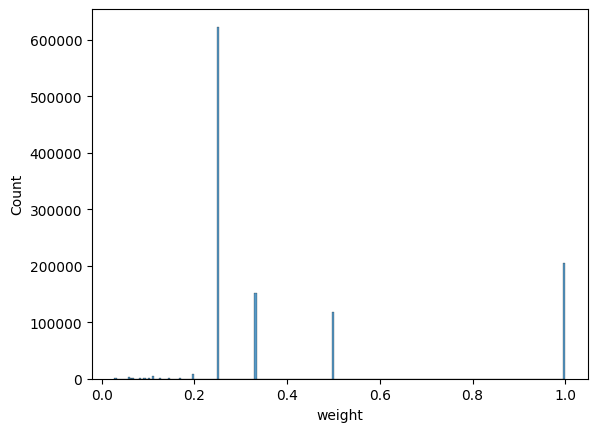

In [30]:
import seaborn as sns

sns.histplot(gbif_matched, x="weight")

In [ ]:

# 06. Select final columns and save
output_columns = [
    "specieskey",
    "decimallatitude",
    "decimallongitude",
    "datasetkey",
    "eventdate",
    "pft",
    "weight",
]

gbif_filtered = gbif_matched[output_columns]

# Save to parquet
output_fp = gbif_prep_dir / cfg.gbif.interim.filtered
log.info(f"Saving filtered GBIF data to {output_fp}...")

gbif_filtered.to_parquet(
    output_fp,
    compression="zstd",
    write_index=False,
)

log.info("Done! Computing final statistics...")

# Compute and log statistics
n_records = len(gbif_filtered)
n_species = gbif_filtered["specieskey"].nunique().compute()
n_datasets = gbif_filtered["datasetkey"].nunique().compute()

log.info(
    f"Filtered GBIF data: {n_records:,} records, "
    f"{n_species:,} unique species, {n_datasets:,} datasets"
)